In [2]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models
from skimage import exposure, filters, segmentation, measure, color, morphology
import pandas as pd
import napari
from scipy import stats
import skimage
import seaborn as sns

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define useful functions

In [3]:
def segment_channel(fname, mip_fname, z_slice, nuc_diam, channel, r_out, r_in):
    '''This function will streamline the segmentation, labeling, and measurement code blocks
    that were used in a previous version of this notebook into one function.'''
    
    # Initialize indices that we can use as a handle for mean intensity data for the channel
    channels = ['mean_intensity_Sqh-mCh', 'mean_intensity_YFP', 
                'mean_intensity_CFP', 'mean_intensity_FRET']
    
    # Segment nuclei and generate labels/rois
    image, mask = segment_image(fname, mip_fname, z_slice, nuc_diam, channel)
    # Measure from rois
    im_slice, rois = label_regions_at_z(image, mask, z_slice)
    
    # Generate donut around nucleus ROI as background for background subtraction
    label = morphology.label(mask)
    expanded = segmentation.expand_labels(label, distance=r_out)
    expanded_1 = segmentation.expand_labels(label, distance=r_in)
    background_mask = expanded ^ expanded_1
    
    im_slice, bg_rois = label_regions_at_z(image, background_mask, z_slice, bg_sub=True)
    rois[channels[channel] + '_corr'] = rois[channels[channel]] - bg_rois[channels[channel]]
    
    # Visualize
    visualize_rois(im_slice, rois, mask)
    visualize_rois(im_slice, bg_rois, background_mask)
    
    return rois, mask, im_slice

In [4]:
def get_fret_measurements(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for i in range(len(delayed_nuc_labels)):
            fret_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_FRET']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_YFP']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_FRET']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_labels[i] - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [5]:
def load_coords(csv_fname):
    '''This function will take in a csv filename as an input and then output a list
    which contains the x-y coordinates of the nuclei of interest.'''
    
    coords = pd.read_csv(csv_fname)
    
    coord_list = list()
    
    for i in range(0, len(coords)):
        x = coords.at[i, 'X']
        y = coords.at[i, 'Y']
        coord_list.append([x, y])
    return coord_list

In [6]:
def match_coords(coords, df, max_distance=20):
    '''This function will take in coordinate data and match the label which is closest to
    that coordinate.'''
    labels = list()
    for i in range(0, len(coords)):
        x_1 = coords[i][0]
        y_1 = coords[i][1]
        point_1 = np.array([x_1, y_1])
        min_distance = max_distance # Define threshold
        for j in range(0, len(df)):
            y_2 = df.at[j, 'centroid-0']
            x_2 = df.at[j, 'centroid-1']
            point_2 = np.array([x_2, y_2])
            #print(point_2)
            dist = np.linalg.norm(point_1 - point_2) # Calculate distance
            #print(dist)
            if dist < min_distance:
                min_distance = dist
                label_idx = j
        labels.append(df.at[label_idx, 'label'])
    return labels

In [7]:
def match_labels(df_1, df_2, mean_channel_intensity, max_distance=20 ):
    '''This function will match the measurements from two different segmentations and merge
    results into one dataframe. Each segmentation will result in some mean intensity measurement
    and this function will map those measurements into one.'''
    mean_ints = list()
    for i in range(0, len(df_1)):
        mean_int = np.nan
        x_1 = df_1.at[i, 'centroid-0']
        y_1 = df_1.at[i, 'centroid-1']
        point_1 = np.array([x_1, y_1])
        label_idx = None # Reset label_idx 
        min_distance = max_distance # Define threshold
        
        for j in range(0, len(df_2)):
            x_2 = df_2.at[j, 'centroid-0'] # Get centroid coordinates
            y_2 = df_2.at[j, 'centroid-1']
            point_2 = np.array([x_2, y_2]) 
            
            dist = np.linalg.norm(point_1 - point_2) # Calculate distance
            if dist < min_distance:
                min_distance = dist
                label_idx = j
        
        if label_idx == None:
            mean_ints.append('no match')
            continue        
        elif isinstance(label_idx, int): # Only appends if there was a match        
            mean_ints.append(df_2.at[label_idx, mean_channel_intensity + '_corr'])
        
    
    df_1[mean_channel_intensity + '_corr_seg'] = mean_ints
    if len(mean_ints) == len(df_1): # Ensures that things were matched properly
        return df_1
    else:
        print('error')
        return
            

In [8]:
def get_fret_measurements_3(delayed_nuc_labels, regular_nuc_labels, measurements, mode=1):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            print(delayed_nuc_label, regular_nuc_label)
            cfp_int_delayed = float(measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP_corr_seg'])
            if mode == 1:
                fret_int_delayed = float(measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET_corr_seg'])
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)
            elif mode == 2:
                yfp_int_delayed = float(measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP_corr'])  
                fret_norm_delayed.append(yfp_int_delayed/cfp_int_delayed)        
                            
            cfp_int_regular = float(measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg'])
            if mode == 1:
                fret_int_regular = float(measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET_corr_seg'])
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
            elif mode == 2:
                yfp_int_regular = float(measurements.loc[regular_nuc_label - 1].at['mean_intensity_YFP_corr'])
                fret_norm_regular.append(yfp_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [9]:
def get_fret_measurements_2(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            fret_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP_corr']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET_corr_seg']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP_corr_seg']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [10]:
def get_fret_measurements(delayed_nuc_labels, regular_nuc_labels, measurements, mode='andrew'):
    '''This function will pull out FRET measurements from two paired sets of nuclei.
    It will return two lists of the normalized fret values.'''
    fret_norm_delayed = list()
    fret_norm_regular = list()
    
    if len(delayed_nuc_labels) == len(regular_nuc_labels): # Ensure that you're comparing pairs of nuclei
        for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
            fret_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_FRET']
            if mode == 'andrew':
                yfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_YFP']       
                fret_norm_delayed.append(fret_int_delayed/yfp_int_delayed)
            elif mode == 'stefano':
                cfp_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_delayed.append(fret_int_delayed/cfp_int_delayed)        

            fret_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_FRET']
            if mode =='andrew':
                yfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/yfp_int_regular)
            elif mode == 'stefano':
                cfp_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_CFP']
                fret_norm_regular.append(fret_int_regular/cfp_int_regular)
        return fret_norm_delayed, fret_norm_regular
    else:
        print('Lengths of label index arrays must be the same')

In [11]:
def get_sqh_measurements(delayed_nuc_labels, regular_nuc_labels, measurements):
    '''This function will pull out Sqh intensity measurements from two paired 
    sets of nuclei.'''
    sqh_delayed = list()
    sqh_regular = list()
    for delayed_nuc_label, regular_nuc_label in zip(delayed_nuc_labels, regular_nuc_labels):
        sqh_int_delayed = measurements.loc[delayed_nuc_label - 1].at['mean_intensity_Sqh-mCh']
        sqh_delayed.append(sqh_int_delayed)

        sqh_int_regular = measurements.loc[regular_nuc_label - 1].at['mean_intensity_Sqh-mCh']
        sqh_regular.append(sqh_int_regular)
    return sqh_delayed, sqh_regular

In [12]:
def plot_paired_fret(normal_fret_vals, delayed_fret_vals, fig_title, save=False, output_dir=None, ylabel='$I_{FRET}/I_{CFP}$ (A.U.)', title=True):
    '''This function will take in the fret values and plot them as a paired
    scatter plot.'''
    # plotting the points
    plt.scatter(np.zeros(len(normal_fret_vals)), normal_fret_vals, color = 'black')
    plt.scatter(np.ones(len(delayed_fret_vals)), delayed_fret_vals, color = 'red')

    # plotting the lines
    for i in range(len(normal_fret_vals)):
        plt.plot( [0,1], [normal_fret_vals[i], delayed_fret_vals[i]],linestyle='--', c='black')

    plt.xticks([0,1], ['Regular', 'Delayed'])
    plt.ylabel(ylabel)
    if title:
        plt.title(fig_title)

    if save:
        plt.savefig(output_dir)
    plt.show()

In [13]:
def paired_ttest(var_1, var_2, alternative='two-sided'):
    t, p = stats.ttest_rel(var_1, var_2, alternative=alternative)
    print('p = ' + str(p))
    if p < 0.05:
        print('The two populations are statistically different')

In [14]:
def segment_image(fname, fname_mip, z, d, channel):
    '''This function will read in an image and segment it at a specific
    optical section, z. This function uses the CellPose package which can
    segment nuclear and cytoplasmic regions. I am only using the nuclear 
    model in this implementation. This model relies on the parameter, d,
    which is the approximate diameter of nuclei, in pixels.
    
    This will output the intensity image and the mask.'''
    
    # Load images
    image = io.imread(fname)
    image_mip = io.imread(fname_mip)
    #p2, p98 = np.percentile(image[:,channel], (2, 98)) # Comment out because my pre-processing happens in fiji now
    #image_rescale = exposure.rescale_intensity(image[:,channel], in_range=(p2, p98))
    
    model = models.Cellpose(model_type='nuclei')
    channels = [0, 2]
    
    # Segmentation step
    mask, flow, style, diam = model.eval(image_mip, diameter=d, channels=channels)
    mask = segmentation.clear_border(mask, buffer_size=5)
    
    # Visualization step
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(image[z,channel])
    ax[0].set_title('Optical Slice')
    ax[1].imshow(image_mip)
    ax[1].set_title('Max. Int. Proj.')
    ax[2].imshow(mask)
    ax[2].set_title('Segmented')
    ax[3].imshow(image[z,channel])
    ax[3].imshow(mask, alpha=0.5)
    ax[3].set_title('Slice/Mask Overlay')
    fig.tight_layout()
    
    return image, mask

In [15]:
def local_bg_sub(image, df_measurement, label, z, channel, ch_idx, viz=False, r_out=10, r_in=2):
    '''This will background subtract each nucleus using an annulus around that nucleus.'''
    
    expanded = segmentation.expand_labels(label, distance=r_out)
    expanded_1 = segmentation.expand_labels(label, distance=r_in)
    
    image_slice, df_measurement_corr = label_regions_at_z(image, expanded ^ expanded_1, z)
    
    df_measurement_corr[channel + '_corr'] = measured_regions_t0[channel] - measured_regions_test[channel]
    
    # Visualization step
    if viz:
        fig, ax = plt.subplots(1, 4)
        ax[0].imshow(label)
        ax[0].set_title('label')
        ax[1].imshow(expanded)
        ax[1].set_title('expanded label')
        ax[2].imshow(expanded ^ expanded_1)
        ax[2].set_title('subtracted roi')
        ax[3].imshow(image_slice)
        ax[3].set_title('raw image')
    
    return df_measurement_corr

In [16]:
def label_regions_at_z(image, label, z, bg_sub=False):
    '''This function will take in the intensity and binary images and generate a pandas dataframe
    that will have the relevant properties for measuring FRET intensities.'''
    
    im_slice = image[z]
    im_slice = np.moveaxis(im_slice, 0, 2)
    
    if not bg_sub:
        label = measure.label(label)
    measured_regions = measure.regionprops_table(label, im_slice, properties=['label', 'centroid', 'area', 'bbox',
                                                                            'intensity_image', 'mean_intensity',
                                                                            'slice'])
    measured_regions = pd.DataFrame(measured_regions)
    measured_regions = measured_regions.rename(columns={'mean_intensity-0':'mean_intensity_Sqh-mCh',
                                 'mean_intensity-1':'mean_intensity_YFP',
                                 'mean_intensity-2':'mean_intensity_CFP',
                                 'mean_intensity-3':'mean_intensity_FRET'})
    
    return im_slice, measured_regions

In [17]:
def visualize_rois(image, rois, mask):
    ''' This function uses napari viewer to visualize the ROIs and allow the user to identify which
    labels correspond to delayed or normally cycling nuclei.'''
    
    # Get the centroids and label values from the label image
    centroid_coords = np.column_stack([
        rois['centroid-0'],
        rois['centroid-1']
    ])

    # Store the labels for each region in a properties dictionary
    points_properties = {'label': rois['label']}
    
    # Start napari viewer
    with napari.gui_qt():
        # create a viewer with the raw data and label image
        viewer = napari.view_image(image[:,:,3], name='FRET')
        viewer.add_image(image[:,:,0], name='Sqh-mCh')
        viewer.add_image(image[:,:,1], name='YFP')
        viewer.add_image(image[:,:,2], name='CFP')
        viewer.add_labels(mask, name='label ID')

        # add a points layer to display the text at the centroid of each
        # labeled region. By setting text='label', the text value for each point
        # will be the corresponding value in the 'label' property in the layer.properties dictionary.
        # note that we set the face and edge colors to  transparent so only the text is visible
        viewer.add_points(
            centroid_coords,
            edge_color = 'transparent',
            face_color = 'transparent',
            properties=points_properties,
            text='label'
        )

In [18]:
def save_fret_measurements(fret_vals_norm, fret_vals_del, fname):
    
    # Save the FRET measurements as a csv so it can be re-plotted in another software
    for_export = pd.DataFrame({"Normal Nuclei (I_FRET/I_CFP)":fret_vals_norm, 
                               "Delayed Nuclei (I_FRET/I_CFP)":fret_vals_del})
    for_export.to_csv(fname)

# Analysis Notes

For the series 8 movie, there are 7 delayed nuclei that I observed. They are towards the bottom-left side of the movie and on the middle-left side.

For this analysis, I wanted to analyze t=2, 8, and 9. I vary the z-slice for each timepoint because the nuclei move along the z-axis during the cell cycle. I will note the z for each timepoint below. Furthermore, because nuclei are also falling, I'm just going to note that for each timepoint, I may take two z-slice measurements to account for the falling nuclei.

<ul>
    <li>t=2: z=13</li>
    <li>t=8: z=13 and 20</li>
    <li>t=9: z=12 and 20
</ul>

Another note: Segmentation in the FRET channel is challenging, even after idealizing images to segment from using the pre-processing script. To get around this, I've been manually beautifying images in the FRET channel for segmentation then measuring off of the raw image. Segmentation from the other channels are still using the MIPs from the script.

## t=8 analysis

I found that I can manually idealize the images for segmentation to make sure that my nuclei of interest are captured. I had to do this for the YFP and the FRET channel. For the YFP channel, the signal was too good for normal nuclei such that cellpose was struggling to recognize delayed nuclei. Further alteration of the image allowed cellpose to recognize the nuclei of interest.

For the FRET channel, it was the opposite where the signal was bad and was struggling to segment most nuclei. Further alteration then allowed better recognition of other nuclei.

The CFP channel remained unchanged from the pre-processing script.

I found from the raw image that nuclear region for the normal nuclei are maximized at z=13 whereas the nuclear region for delayed nuclei are maximized at z=20. When comparing measurements later, I'll use the values measured from z=13 and z=20 for normal and delayed nuclei, respectively. Nevertheless, I will also compare the values between both classes on the same plane just to see.

## t=9 analysis

I also had to manually change the images to segment off of in t=9. Notably, I think what's messing up with the quality of the segmentation image is that nuclei are not on the same plane anymore. And so, a max stack going from top to bottom will also bias the MIP. A lot of the manual changes I had to do was just changing the range of the MIP. 

Something that's a bit more nuanced is that for the CFP channel segmentation, I had to change the nuclear diameter parameter to 75 for cellpose to not under split the nuclei.

The FRET channel in t=9 was difficult to segment even after manually changing the image. Upon inspection, the CFP channel was a good candidate to segment the FRET channel off of, so I used the idealized image of the CFP channel to segment and gather information from the FRET channel.

I compared measurements at t9_z12 and I see something weird with nucleus 71. This is a great example of why it's important to measure the FRET at different z slices due to the fallout. Looking at the FRET channel there, the signal-to-noise ratio is not great because the nucleus has fallen down.

For this timepoint, I will use measurements of normal nuclei from z=12. Also included from z=12 are the measurements of nucleus 45 (or the last delayed nucleus labeled).

The measurements for the rest of the delayed nuclei will be taken from z=20.

# Load Image

In [19]:
# Load image 
data_dir = '../data/20220117_series8/'
fnames = [fname for fname in os.listdir(data_dir) if '.tif' in fname]
fnames.sort()
segment_dir = '../outputs/20220117_series8/mips/'
segment_fnames = [fname for fname in os.listdir(segment_dir) if '.tif' in fname]
segment_fnames.sort()

In [20]:
fnames

['20220117_series8_t00.tif',
 '20220117_series8_t02.tif',
 '20220117_series8_t08.tif',
 '20220117_series8_t09.tif',
 '20220117_series8_t11.tif',
 '20220117_series8_t14.tif']

In [21]:
segment_fnames

['20220117_series8_t00_ch1.tif',
 '20220117_series8_t00_ch2.tif',
 '20220117_series8_t00_ch3.tif',
 '20220117_series8_t00_ch4.tif',
 '20220117_series8_t02_ch1.tif',
 '20220117_series8_t02_ch2.tif',
 '20220117_series8_t02_ch3.tif',
 '20220117_series8_t02_ch4.tif',
 '20220117_series8_t08_ch1.tif',
 '20220117_series8_t08_ch2.tif',
 '20220117_series8_t08_ch3.tif',
 '20220117_series8_t08_ch4.tif',
 '20220117_series8_t09_ch1.tif',
 '20220117_series8_t09_ch2.tif',
 '20220117_series8_t09_ch3.tif',
 '20220117_series8_t09_ch4.tif',
 '20220117_series8_t11_ch1.tif',
 '20220117_series8_t11_ch2.tif',
 '20220117_series8_t11_ch3.tif',
 '20220117_series8_t11_ch4.tif',
 '20220117_series8_t14_ch1.tif',
 '20220117_series8_t14_ch2.tif',
 '20220117_series8_t14_ch3.tif',
 '20220117_series8_t14_ch4.tif']

# Analysis

In [137]:
# Define variables that will be used throughout this timepoint
fname = fnames[3]
mip_fnames = segment_fnames[12:16]
z_slice = 20
nuc_diam = 75

## Segmentation

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. nap

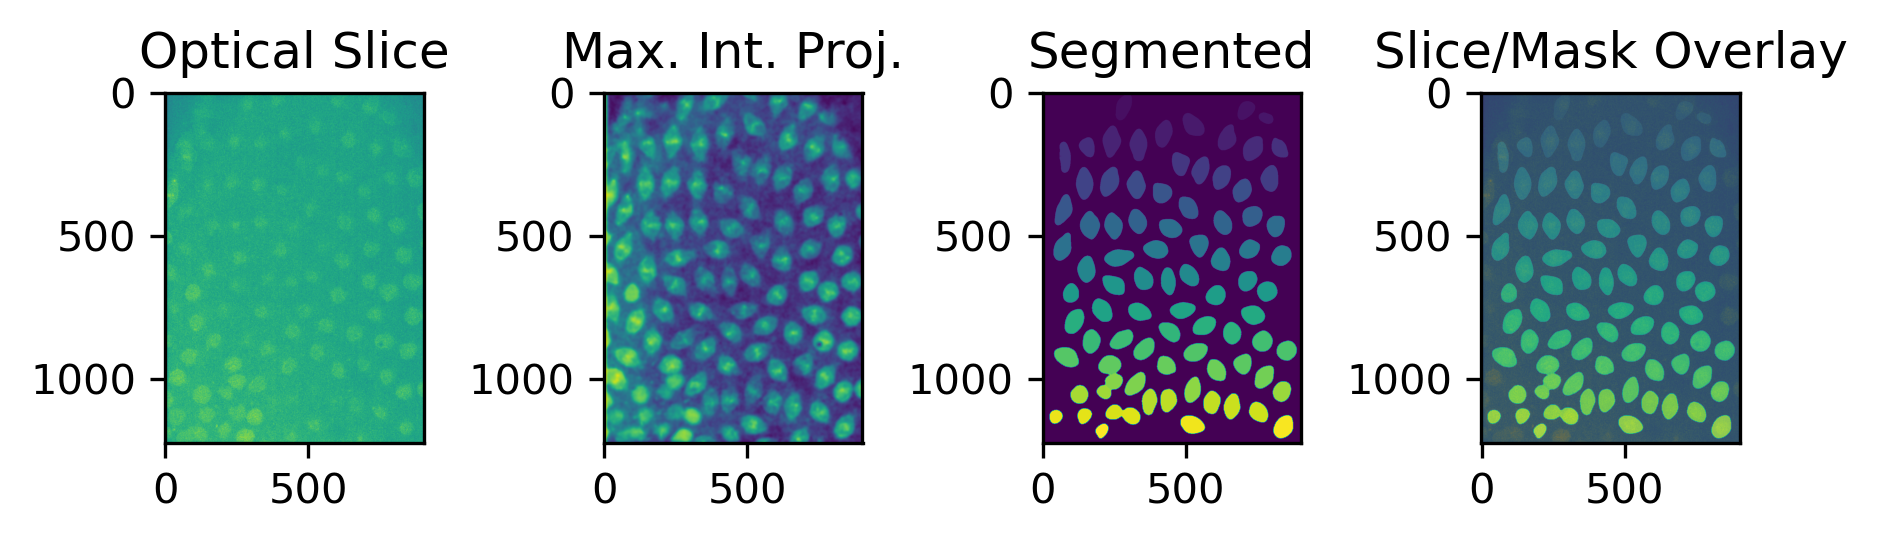

In [138]:
channel = 1
measured_regions_yfp, mask_yfp, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel],
                             z_slice=z_slice, nuc_diam=nuc_diam, channel=channel,
                                       r_out=10, r_in=2)

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. nap

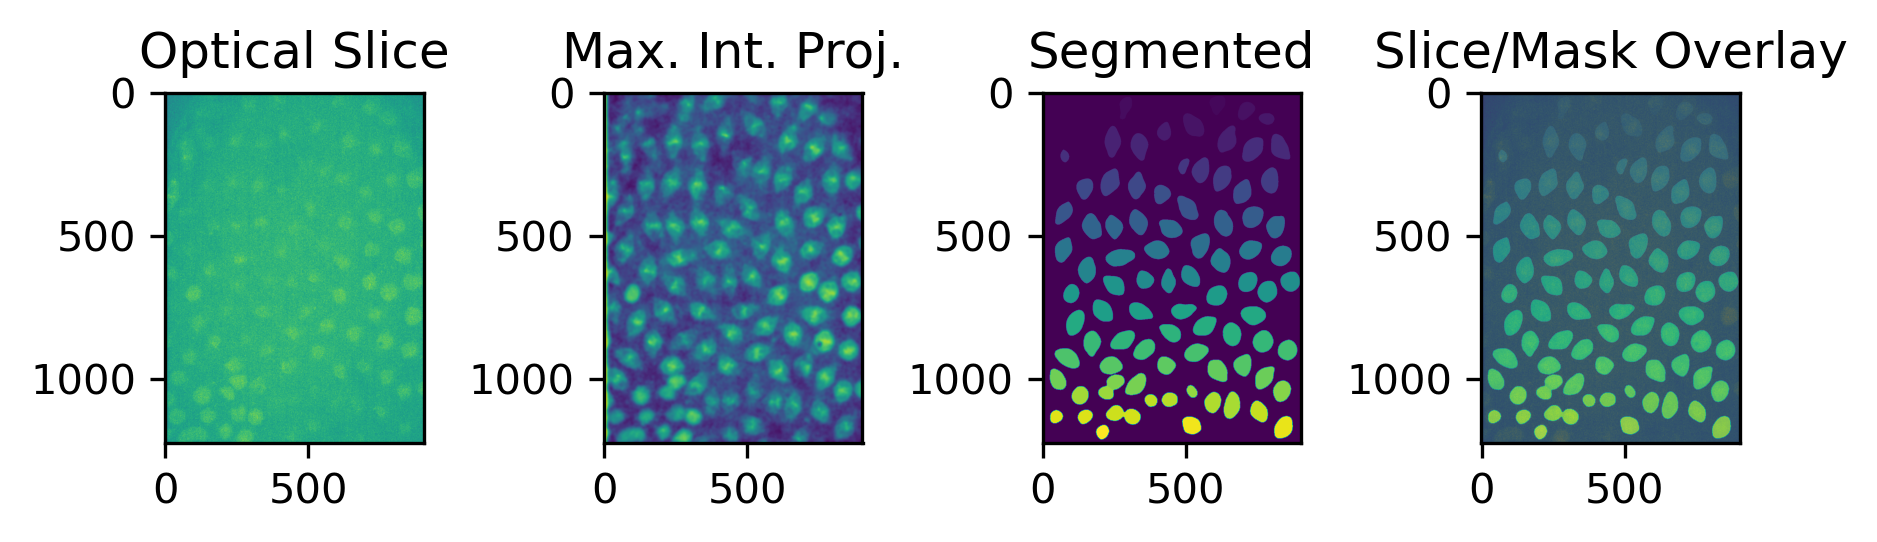

In [139]:
channel = 2
measured_regions_cfp, mask_cfp, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel],
                             z_slice=z_slice, nuc_diam=70, channel=channel,
                                       r_out=10, r_in=2)

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(
/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. nap

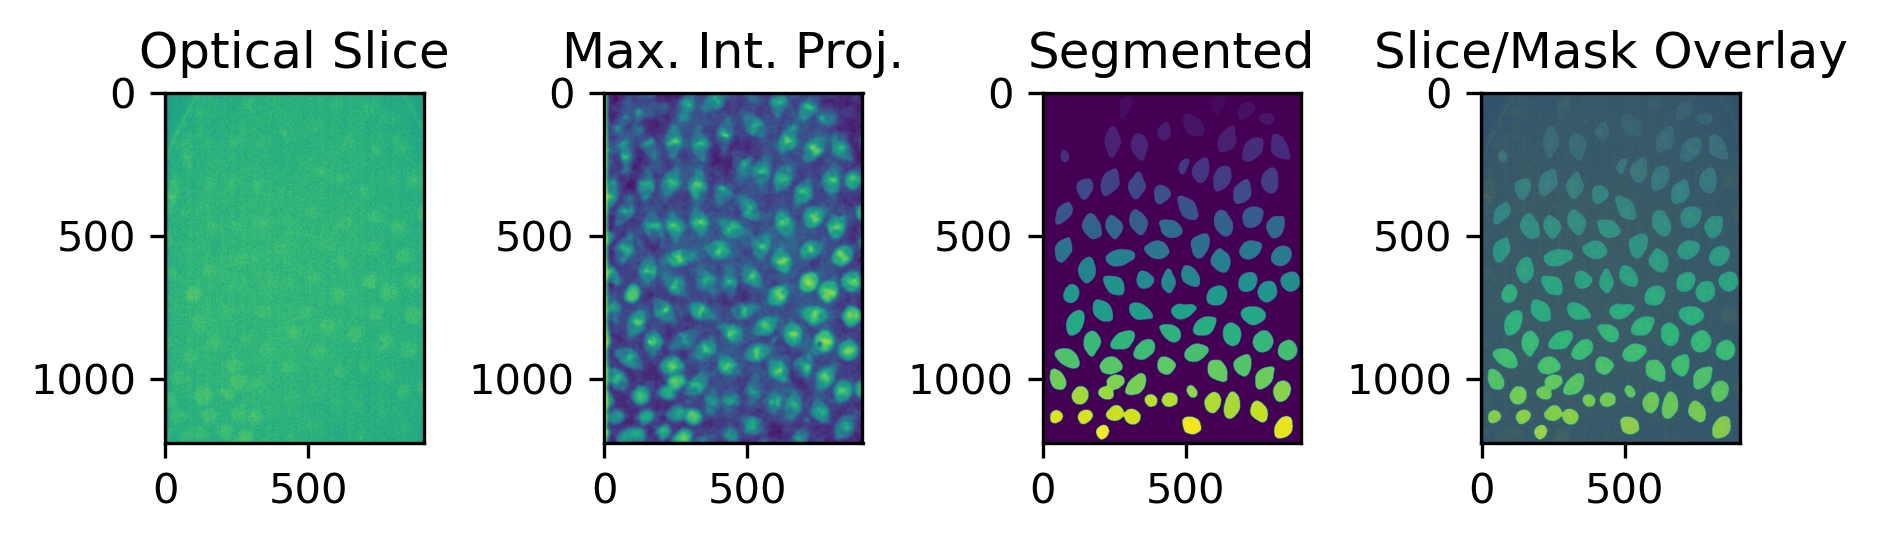

Traceback (most recent call last):
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)


In [140]:
channel = 3
measured_regions_fret, mask_fret, image_slice = segment_channel(data_dir + fname, 
                             segment_dir + mip_fnames[channel - 1],
                             z_slice=z_slice, nuc_diam=70, channel=channel,
                                       r_out=10, r_in=2)

## Merge the measurements from the segmentation

In [141]:
measured_regions_master = match_labels(measured_regions_yfp, measured_regions_cfp, 'mean_intensity_CFP', max_distance=22)
measured_regions_master = match_labels(measured_regions_master, measured_regions_fret, 'mean_intensity_FRET', max_distance=22)

In [142]:
visualize_rois(image_slice, measured_regions_master, mask_yfp) # Pop up of napari viewer to select the labels

/home/aydoganlab/miniconda3/envs/cellpose/lib/python3.8/site-packages/napari/_qt/qt_event_loop.py:265: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  warn(


In [143]:
measured_regions_master.loc[(measured_regions_master['mean_intensity_CFP_corr_seg'] == 'no match') | (measured_regions_master['mean_intensity_FRET_corr_seg'] == 'no match')] # To check for selections that were not properly segmented

,label,centroid-0,centroid-1,area,bbox-0,bbox-1,bbox-2,bbox-3,intensity_image,mean_intensity_Sqh-mCh,mean_intensity_YFP,mean_intensity_CFP,mean_intensity_FRET,slice,mean_intensity_YFP_corr,mean_intensity_CFP_corr_seg,mean_intensity_FRET_corr_seg
9,10,191.362776,154.815983,2853,158,125,228,180,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",243.621101,326.025237,276.988083,241.004206,"(slice(158, 228, None), slice(125, 180, None))",9.109721,no match,no match


### Note
At this point, you should open the timeseries on FIJI and then mark the nuclei of interest using the point label function. Furthermore, you should label nuclei such that the delayed nuclei are labeled first. Subsequently, you should label corresponding, neighboring normal nuclei.

The function above returns some labels that you should avoid. This can be cross-checked by looking at the napari window.

## Classifying Nuclei

The immediate code block below will return the labels of the delayed nuclei, given you input a list of x, y coordinates for it. 

The first line reads in the csv file from FIJI, from where you will determine the coordinates of the delayed nuclei. The second line will then match those coordinates with the segmentation labels to match the ROIs.

The input should be marking the delayed nuclei first. Once all delayed nuclei have been marked in FIJI, you proceed to mark the neighboring normal nucleus, corresponding to each delayed nucleus. In this sense, the first half of coordinates are that of delayed nuclei and the second half of coordinates are the neighboring, corresponding, normal nuclei.

In [144]:
coord_fnames = '../data/20220117_series8/labels_t9.csv'

In [145]:
coords = load_coords(coord_fnames)
delayed_coords = coords[0:int(len(coords)/2)]
regular_coords = coords[int(len(coords)/2):len(coords)]
delayed_labels = match_coords(delayed_coords, measured_regions_master, max_distance=20)
regular_labels = match_coords(regular_coords, measured_regions_master, max_distance=20)

In [146]:
delayed_labels

[68, 71, 78, 79, 80, 72, 45]

In [147]:
fret_delayed, fret_normal = get_fret_measurements_3(delayed_labels, 
                                                        regular_labels, 
                                                        measured_regions_master,
                                                        mode=1)

68 67
71 63
78 73
79 73
80 84
72 61
45 38


In [148]:
plot_title = 'Cdk1 Activity at t=9 and z=20'
output_dir = '../figures/20220117_series8/'
fname = 'fret_t9_z20.png'

In [80]:
os.makedirs(output_dir)

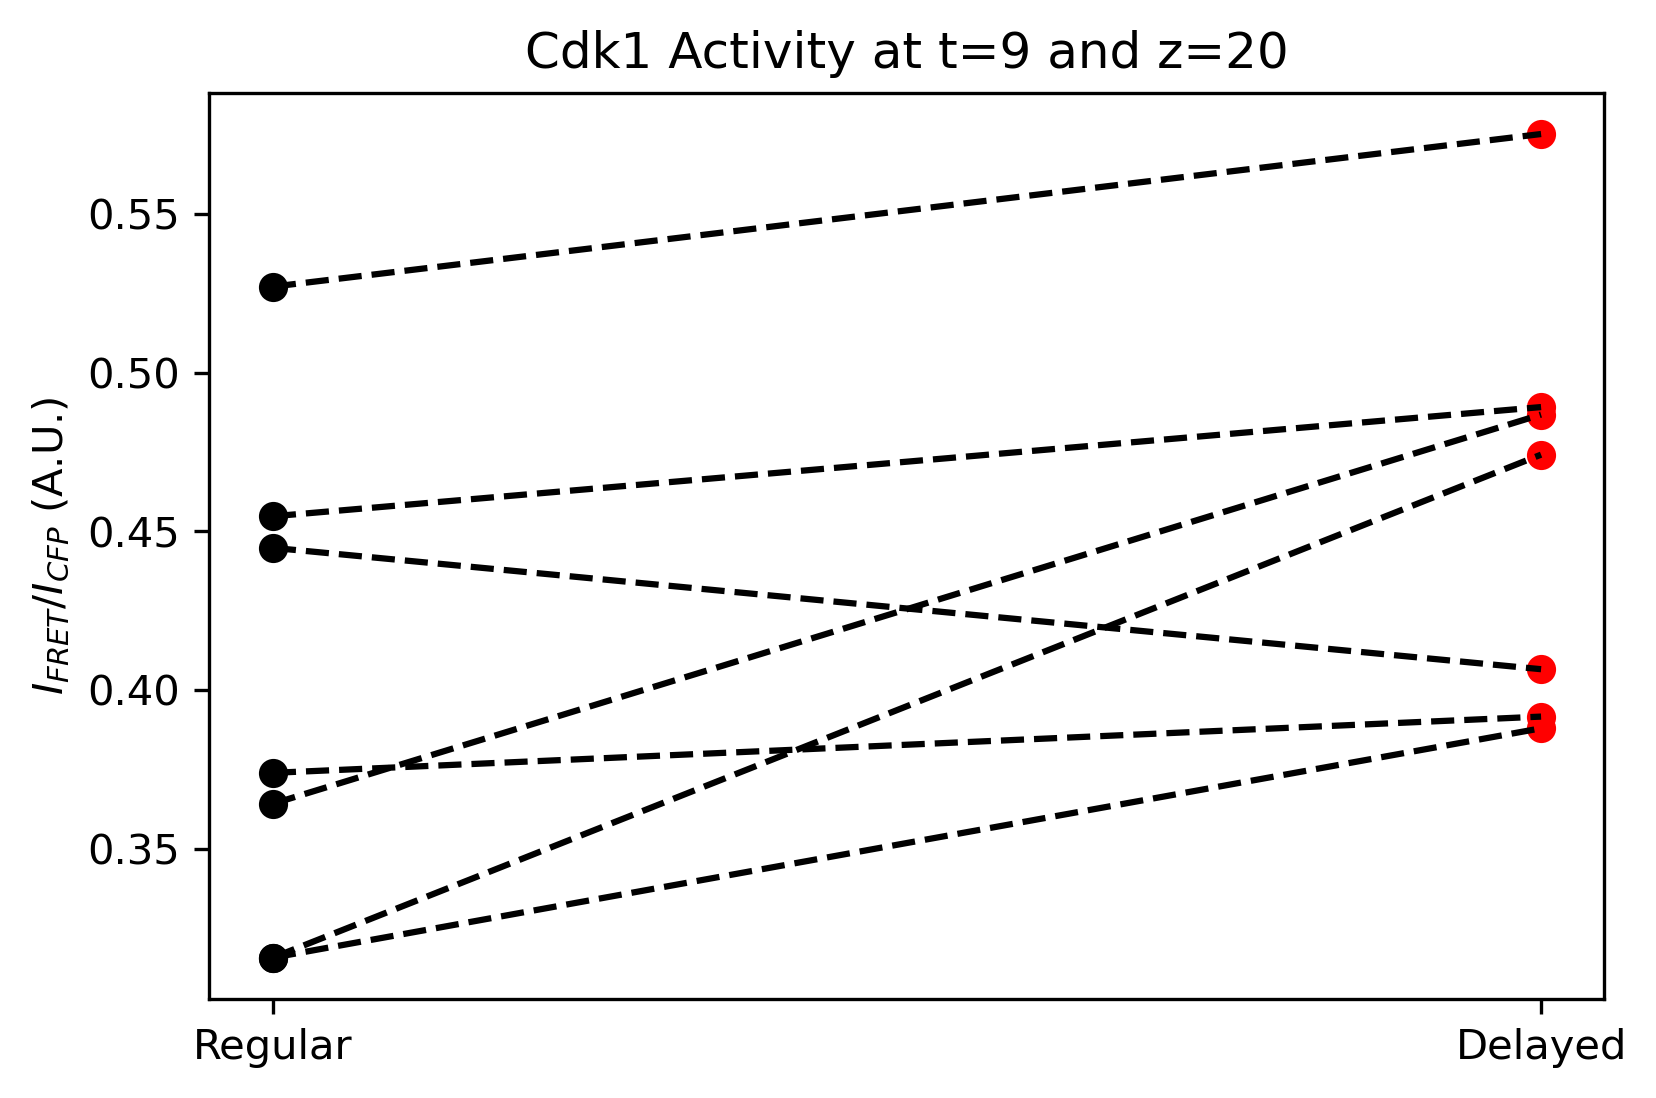

In [149]:
plot_paired_fret(fret_normal, fret_delayed, fig_title=plot_title, save=True, 
                 output_dir=output_dir + fname,
                 ylabel='$I_{FRET}/I_{CFP}$ (A.U.)')

In [150]:
paired_ttest(fret_normal, fret_delayed)

p = 0.0544269653525238


In [151]:
fname_out = '../outputs/20220117_series8/t9_z20_fret_measurements.csv'

In [152]:
# Save measurements
save_fret_measurements(fret_normal, fret_delayed, 
                       fname_out)

In [385]:
fret_delayed_z10, fret_normal_z10 = get_fret_measurements(delayed_labels_z10, 
                                                        normal_labels_z10, 
                                                        measured_regions_z10,
                                                        mode='andrew')

In [386]:
delayed_labels_z16 = [31, 44, 56, 60, 72, 49, 45, 40, 34, 33]
normal_labels_z16 = [26, 37, 51, 67, 78, 55, 38, 36, 46, 29]

In [387]:
fret_delayed_z16, fret_normal_z16 = get_fret_measurements(delayed_labels_z16,
                                                            normal_labels_z16,
                                                            measured_regions_z16,
                                                          mode='andrew')

In [388]:
fret_normal = np.array(fret_normal_z10 + fret_normal_z16)
fret_delayed = np.array(fret_delayed_z10 + fret_delayed_z16)

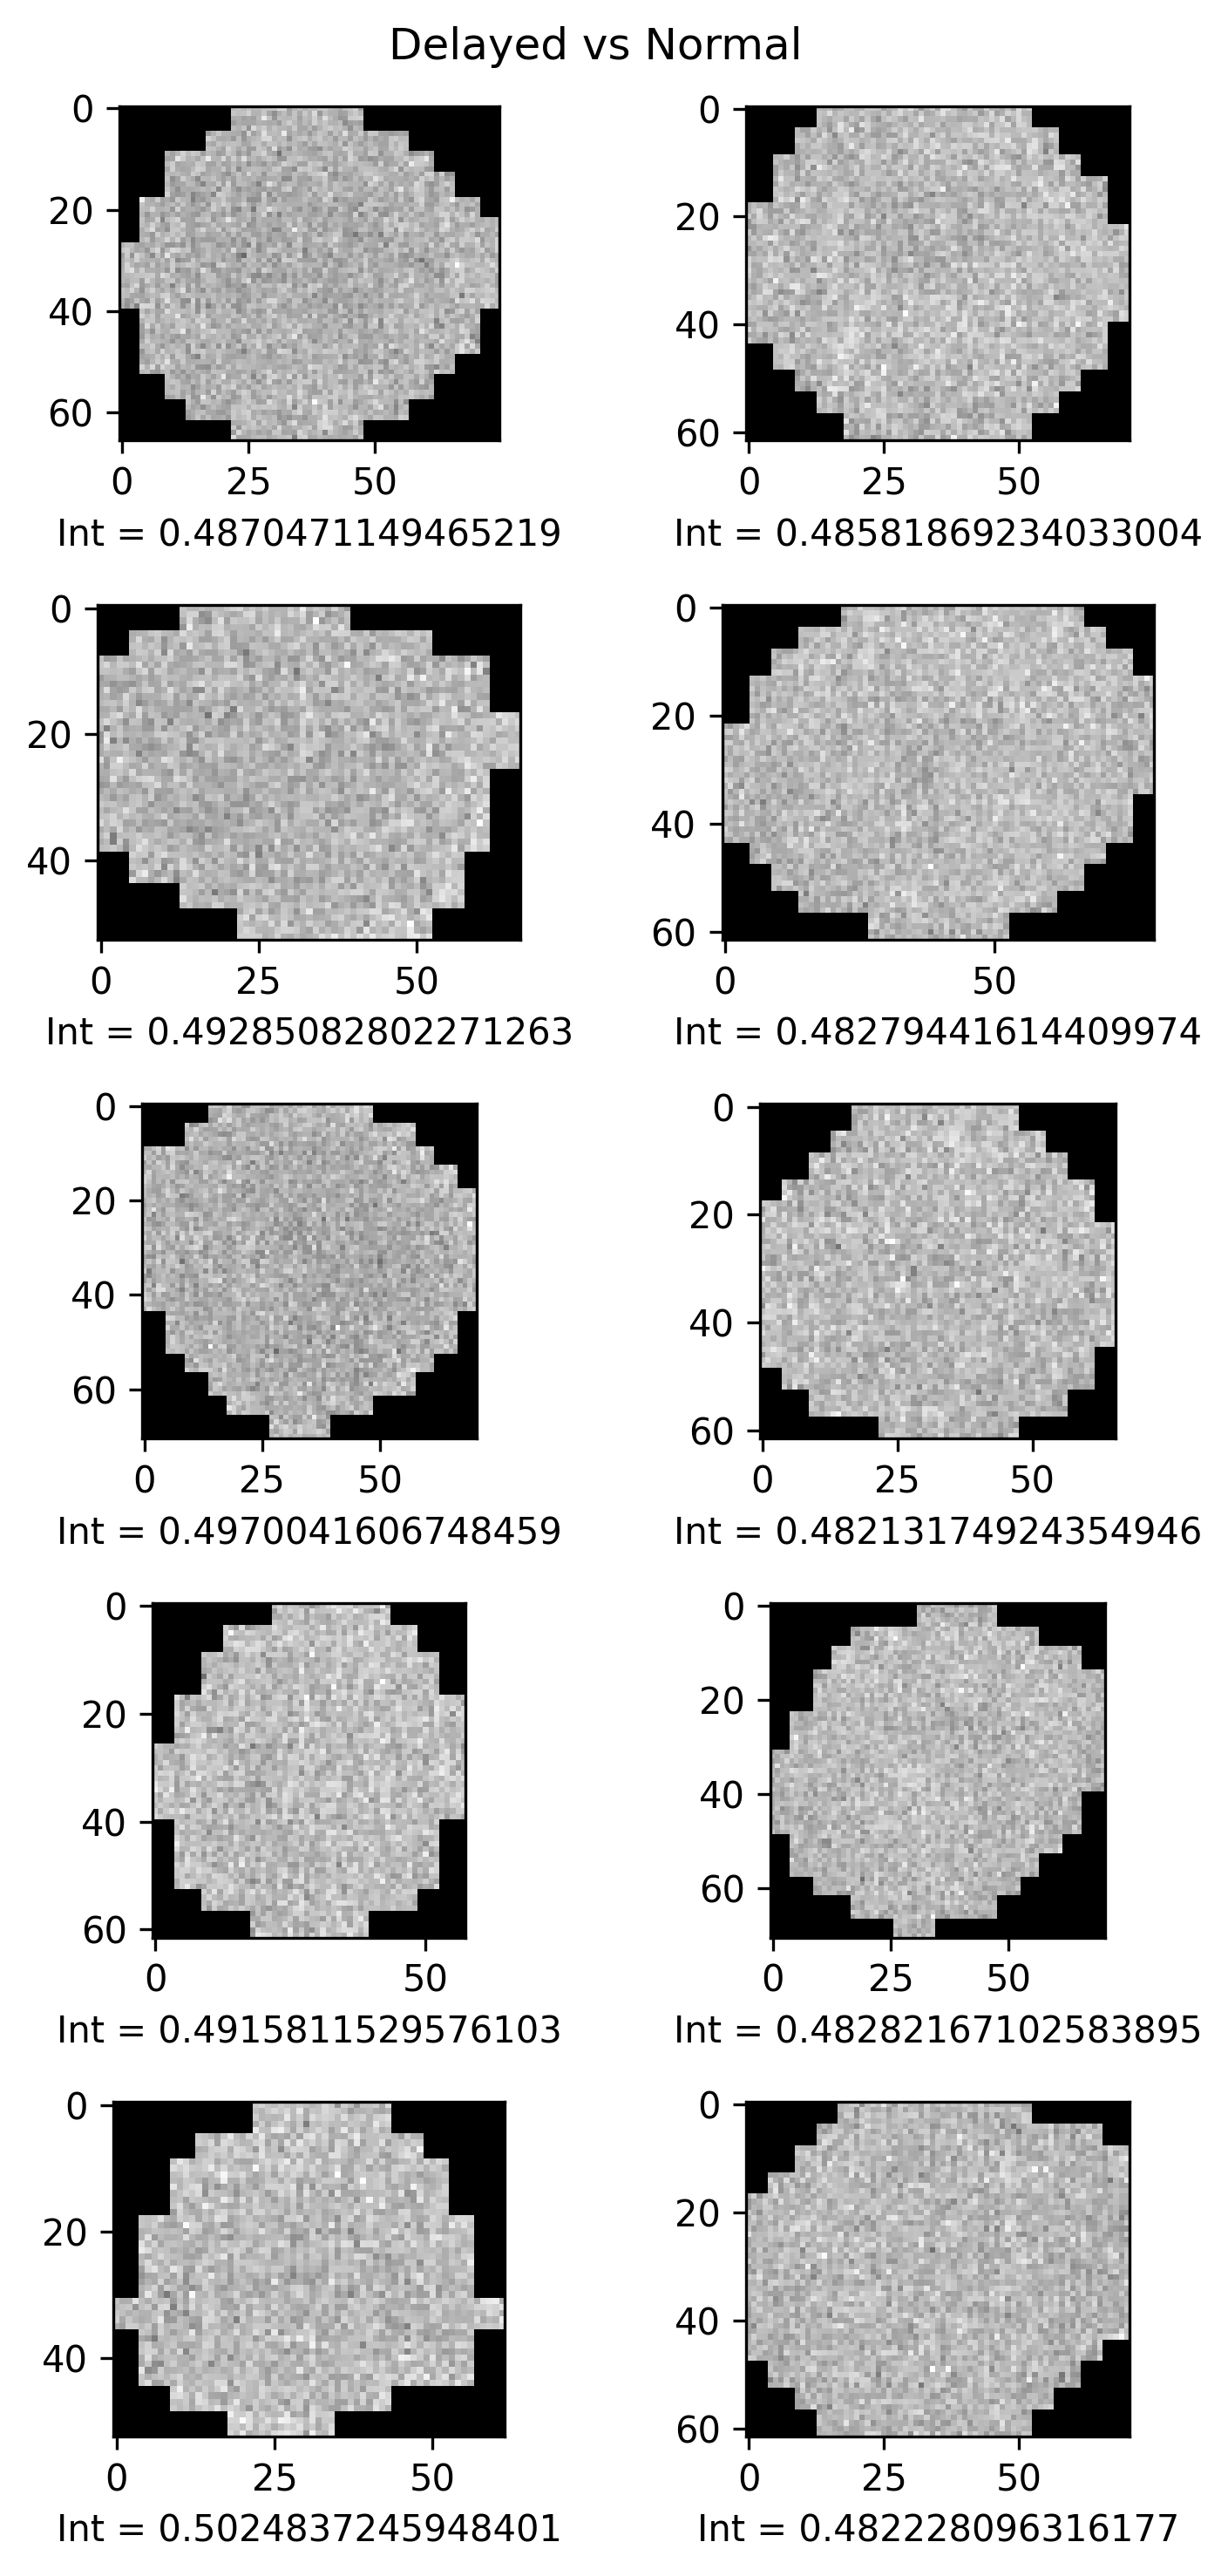

In [298]:
fig, ax = plt.subplots(len(delayed_labels_z10), 2, figsize=(5, 10))
for i in range(len(delayed_labels_z10)):
    ax[i, 0].imshow(measured_regions_z10['intensity_image'][delayed_labels_z10[i] - 1][:,:,0], cmap='gray')
    fret_1 = measured_regions_z10.loc[delayed_labels_z10[i] - 1].at['mean_intensity_FRET']/measured_regions_z10.loc[delayed_labels_z10[i] - 1].at['mean_intensity_YFP']
    ax[i,0].set_xlabel('Int = ' + str(fret_1))
    ax[i, 1].imshow(measured_regions_z10['intensity_image'][normal_labels_z10[i] - 1][:,:,0], cmap='gray')
    fret_2 = measured_regions_z10.loc[normal_labels_z10[i] - 1].at['mean_intensity_FRET']/measured_regions_z10.loc[normal_labels_z10[i] - 1].at['mean_intensity_YFP']
    ax[i,1].set_xlabel('Int = ' + str(fret_2)) 
fig.suptitle('Delayed vs Normal')
fig.tight_layout()
#plt.savefig('../figures/fret_validation_z10.png')

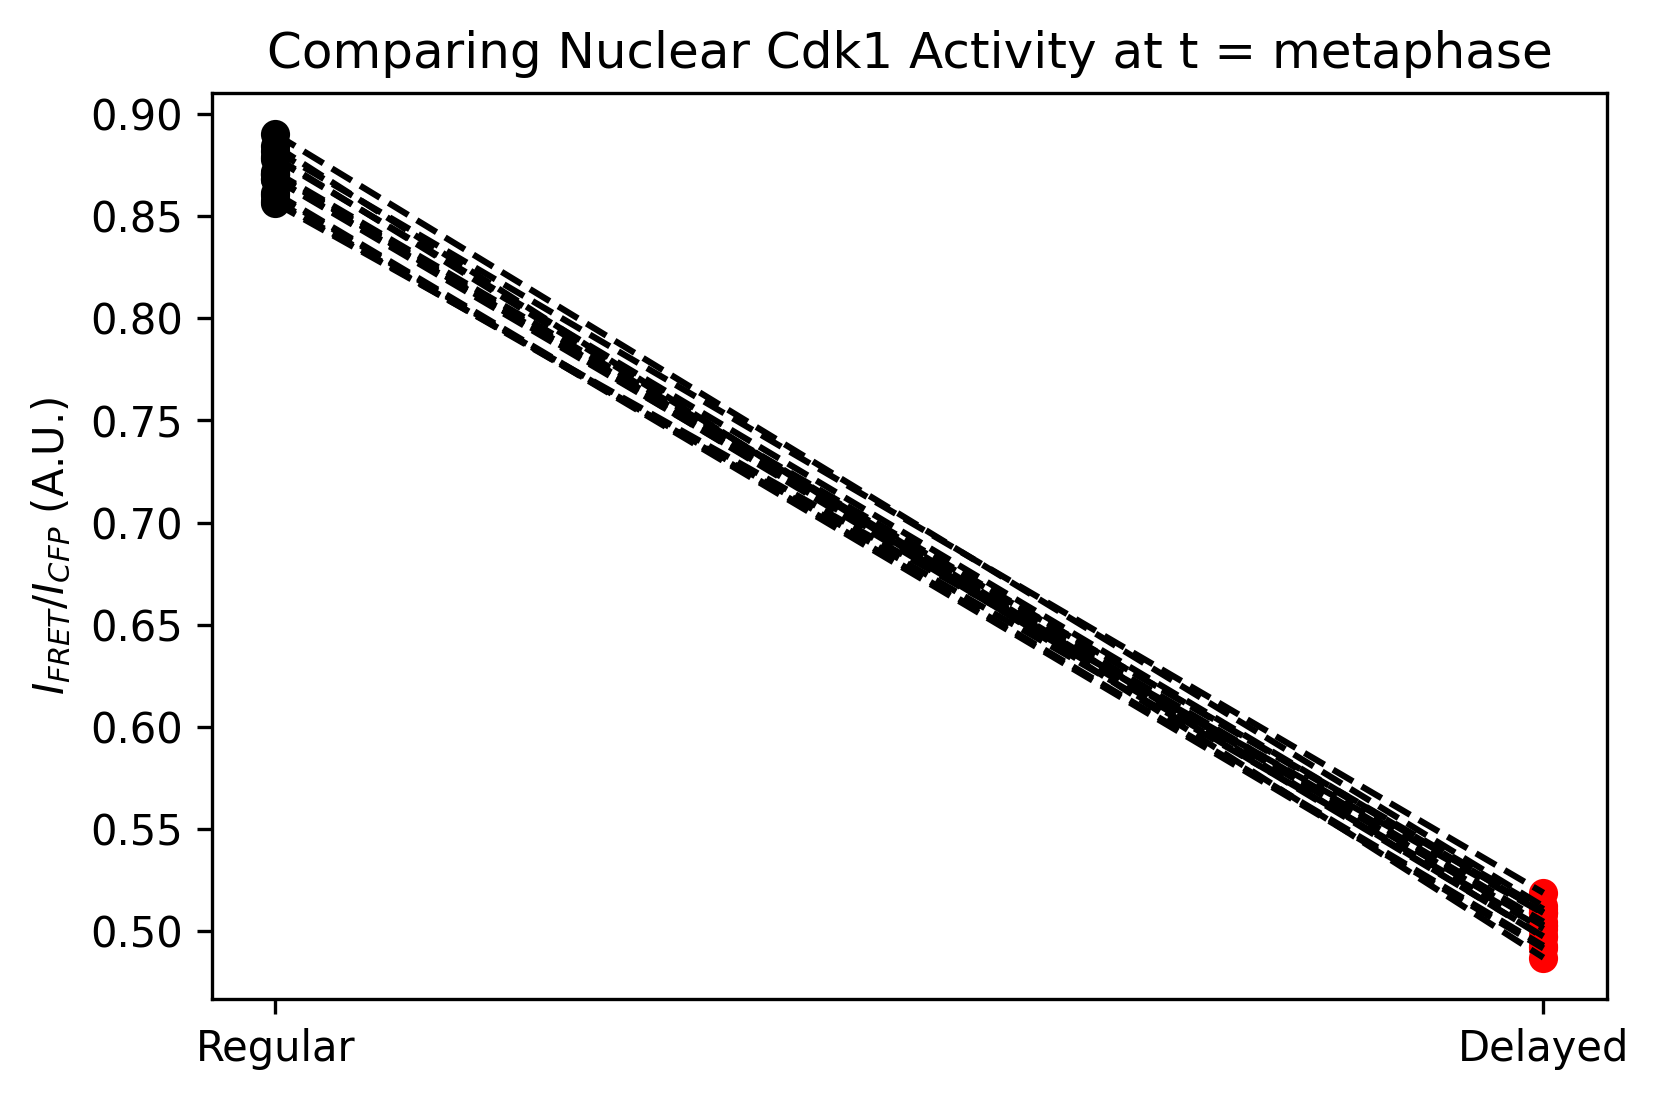

In [389]:
plot_paired_fret(fret_normal, fret_delayed, 'metaphase', save=False, 
                 output_dir='../figures/paired_fret_metaphase.png')

In [266]:
paired_ttest(fret_normal, fret_delayed)

p = 1.3303948734978546e-22
The two populations are statistically different


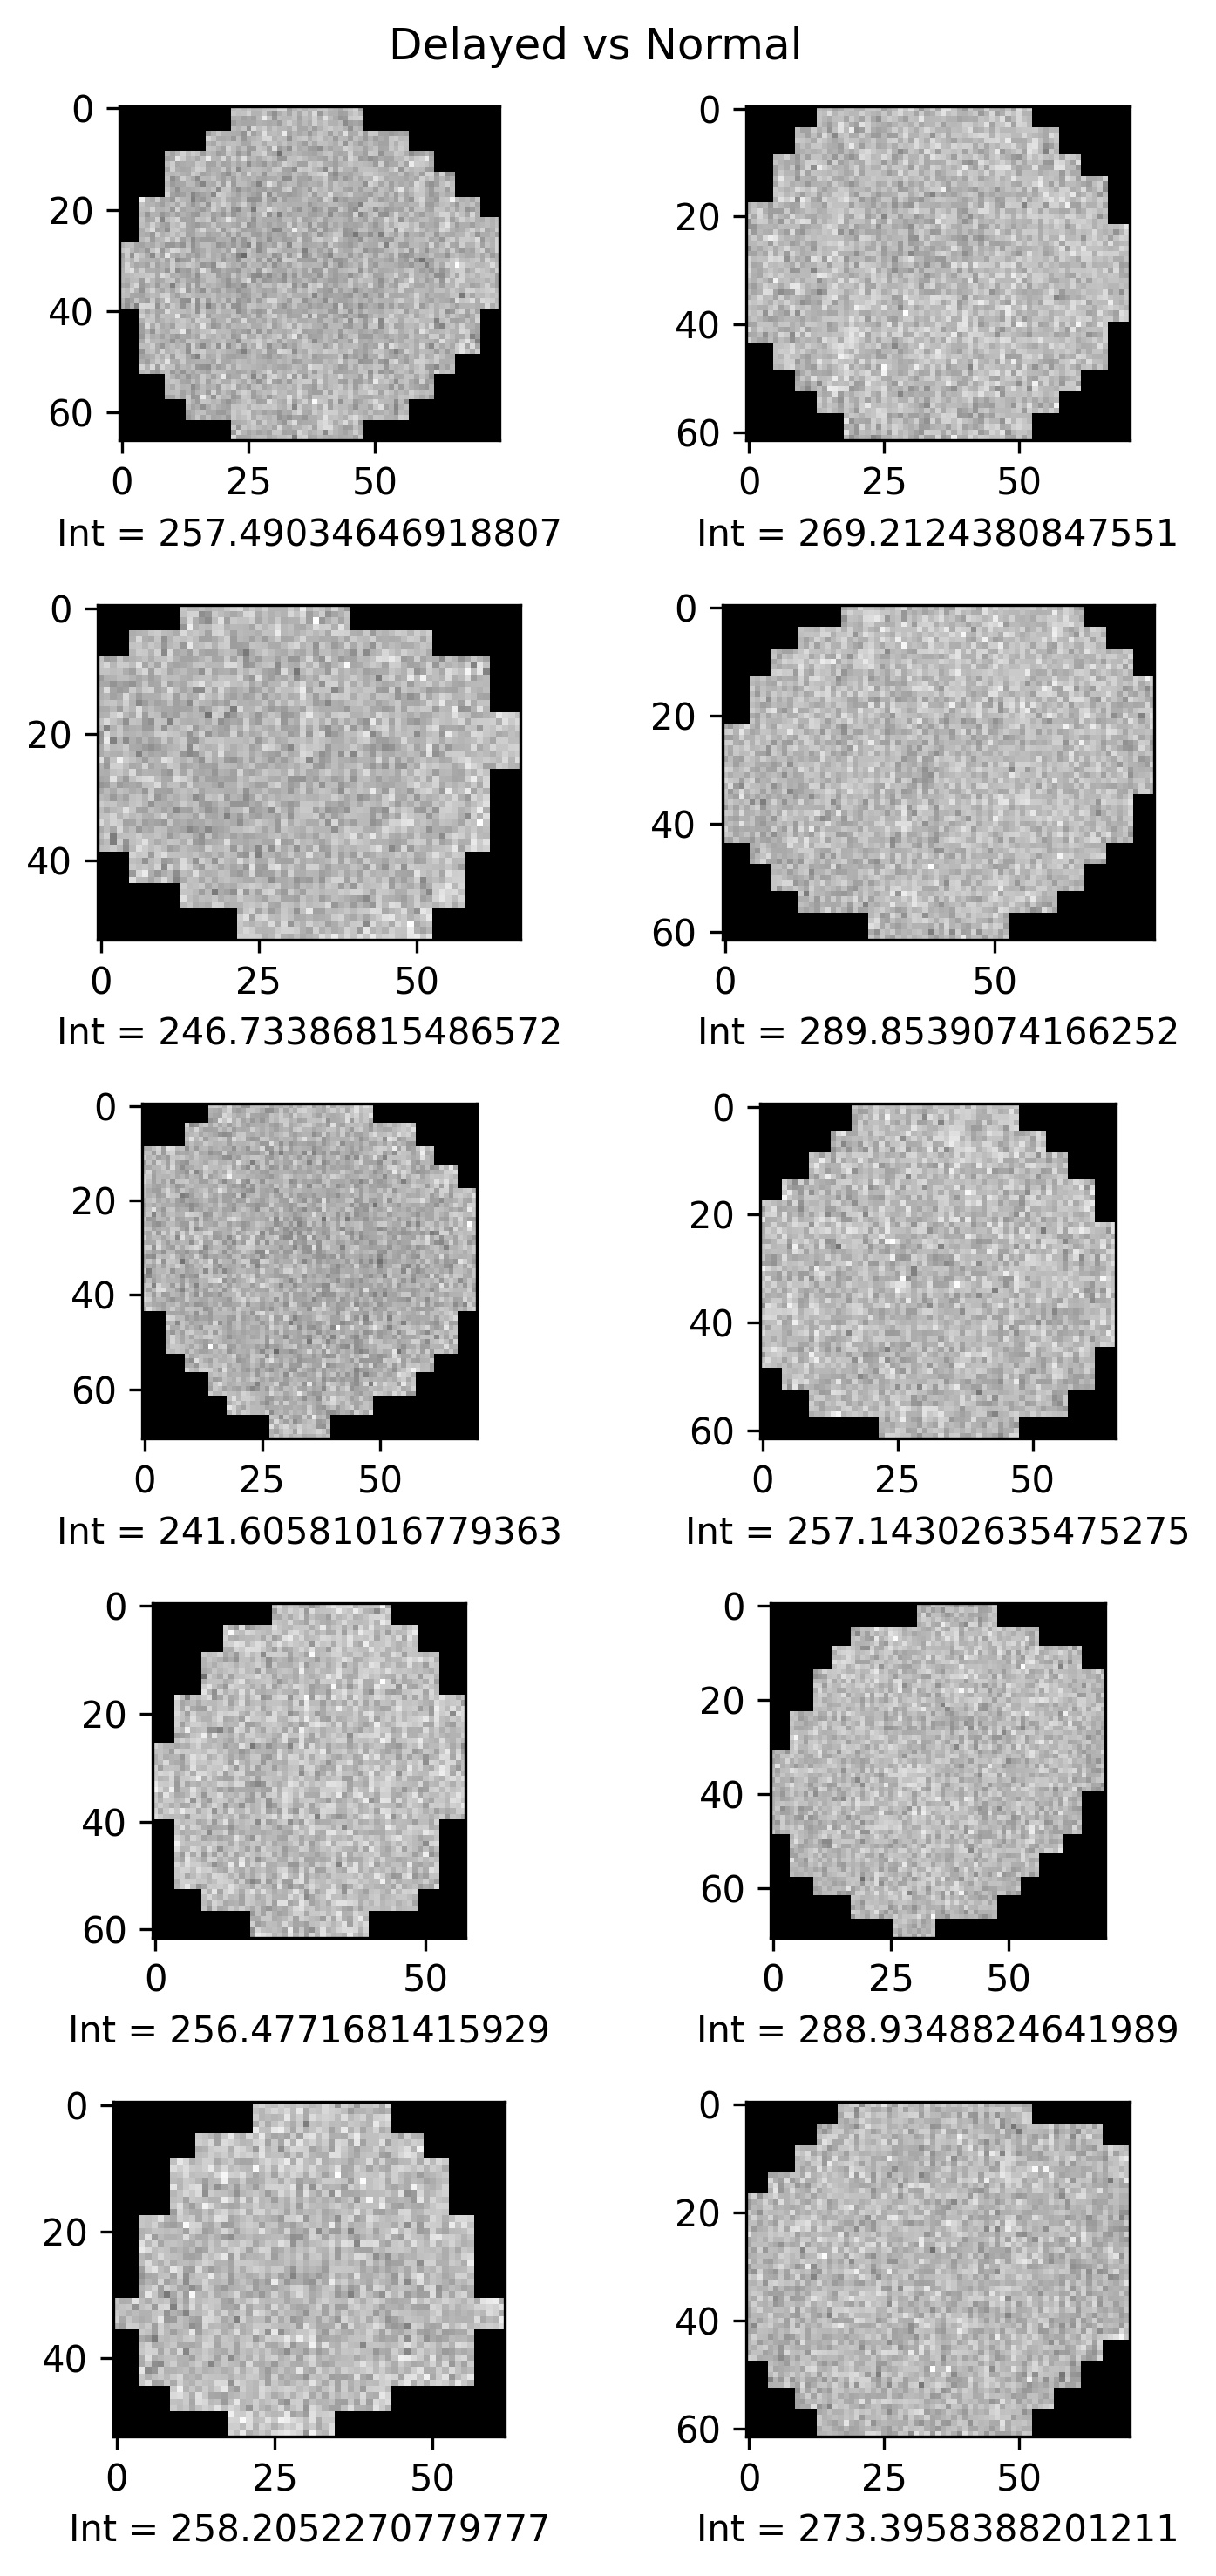

In [267]:
fig, ax = plt.subplots(len(delayed_labels_z10), 2, figsize=(5, 10))
for i in range(len(delayed_labels_z10)):
    ax[i, 0].imshow(measured_regions_z10['intensity_image'][delayed_labels_z10[i] - 1][:,:,0], cmap='gray')
    ax[i,0].set_xlabel('Int = ' + str(measured_regions_z10.loc[delayed_labels_z10[i] - 1].at['mean_intensity_Sqh-mCh']))
    ax[i, 1].imshow(measured_regions_z10['intensity_image'][normal_labels_z10[i] - 1][:,:,0], cmap='gray')
    ax[i,1].set_xlabel('Int = ' + str(measured_regions_z10.loc[normal_labels_z10[i] - 1].at['mean_intensity_Sqh-mCh']))              
fig.suptitle('Delayed vs Normal')
fig.tight_layout()
#plt.savefig('../figures/sqh_validation_z10.png')

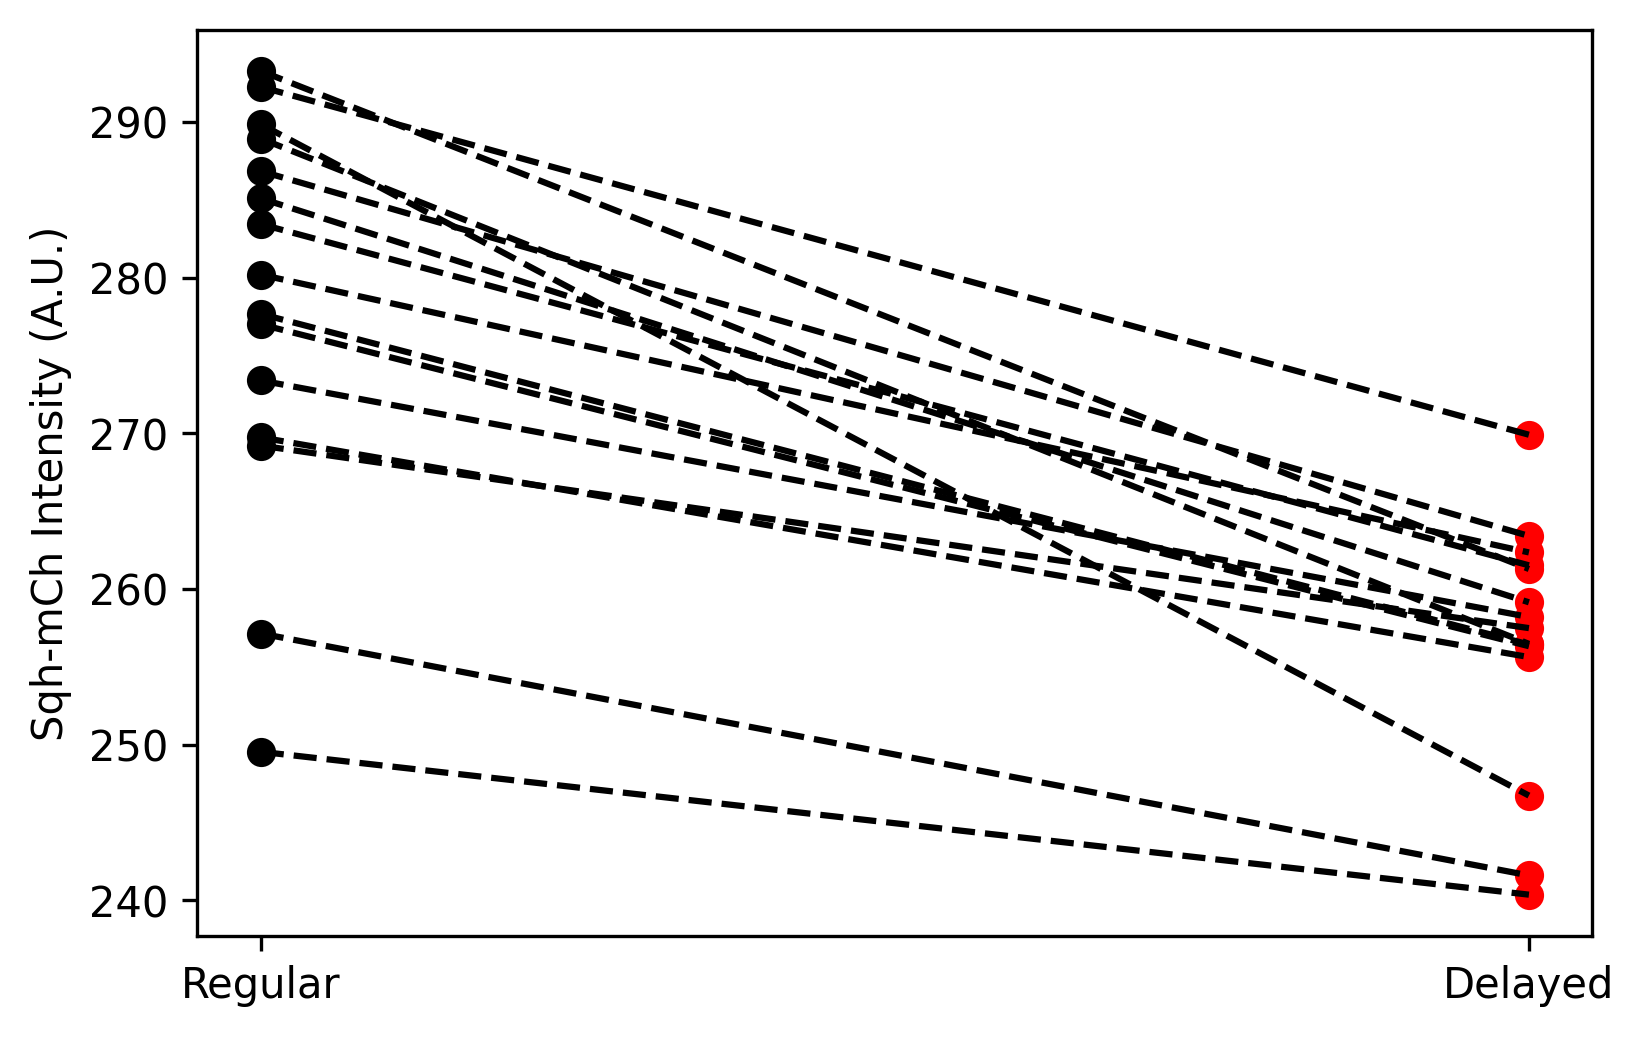

In [306]:
sqh_delayed_z10, sqh_normal_z10 = get_sqh_measurements(delayed_labels_z10,
                                                     normal_labels_z10, 
                                                     measured_regions_z10)

sqh_delayed_z16, sqh_normal_z16 = get_sqh_measurements(delayed_labels_z16,
                                                            normal_labels_z16,
                                                            measured_regions_z16)

sqh_normal = np.array(sqh_normal_z10 + sqh_normal_z16)
sqh_delayed = np.array(sqh_delayed_z10 + sqh_delayed_z16)

plot_paired_fret(sqh_normal, sqh_delayed, time='metaphase', ylabel='Sqh-mCh Intensity (A.U.)',
                title=False, save=False, output_dir='../figures/paired_sqh_intensity_metaphase.png')

In [269]:
paired_ttest(sqh_normal, sqh_delayed)

p = 1.8424765300476385e-07
The two populations are statistically different


* Find a representative embryo with representative nuclei, then forward MGA.
* Get Anand to give me coordinates of the other extra duplication but no delay
* ANOVA